<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project6_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [305]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import time

# to make this notebook's output stable across runs
np.random.seed(42)

from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

# Clustering Bridge Image Dataset

##Data Scrubing

## Loading Data

In [306]:
bridge = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/bridge.txt', sep="    ", header=None) #the original file has 4 spaces separated

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [307]:
bridge.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1


Since the binarized pixel dataset was used; therefore, the data itself was already cleaned.

In [308]:
bridge.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [309]:
bridge.shape

(2813, 16)

Separate X and y

In [0]:
X_bridge = bridge.shape[0]
y_bridge = bridge.shape[1]

Generate isotropic Gaussian blobs for clustering

In [0]:
X_bridge, y_bridge = make_blobs(n_samples=len(bridge), random_state=42)

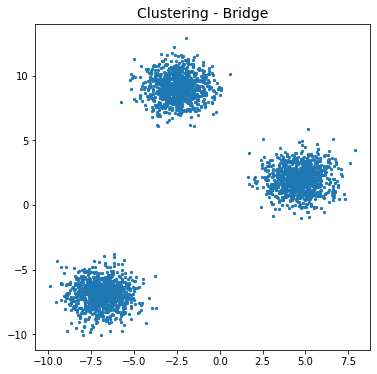

In [312]:
plt.figure(figsize=(6,6))
plt.scatter(X_bridge[:, 0], X_bridge[:, 1], s=5)
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

## K-Means

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [0]:
y_pred = kmeans.fit_predict(X_bridge)

In [315]:
y_pred

array([1, 1, 0, ..., 2, 2, 2], dtype=int32)

In [316]:
len(y_pred)

2813

In [317]:
y_pred is kmeans.labels_

True

Therefore, y_pred is the label (0, 1, 2) tha represents for each cluster.

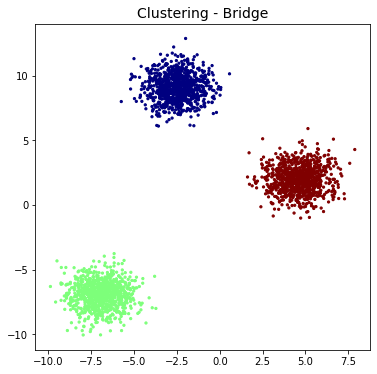

In [318]:
plt.figure(figsize=(6,6))
plt.scatter(X_bridge[:, 0], X_bridge[:, 1], c=y_pred, s=5, cmap='jet')
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

And the following 3 _centroids_ (i.e., cluster centers) were estimated:

In [319]:
kmeans.cluster_centers_

array([[-2.47310574,  9.06426776],
       [-6.92729786, -6.92424284],
       [ 4.6329457 ,  1.99817193]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [320]:
kmeans.labels_

array([1, 1, 0, ..., 2, 2, 2], dtype=int32)

Of course, we can predict the labels of new instances:

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

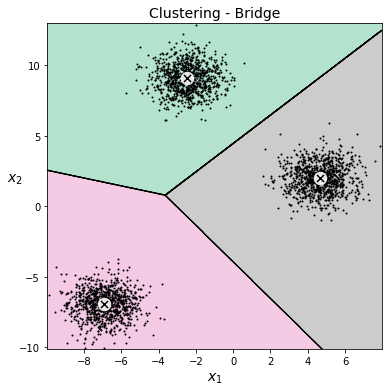

In [322]:
plt.figure(figsize=(6, 6))
plot_decision_boundaries(kmeans, X_bridge)
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [0]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

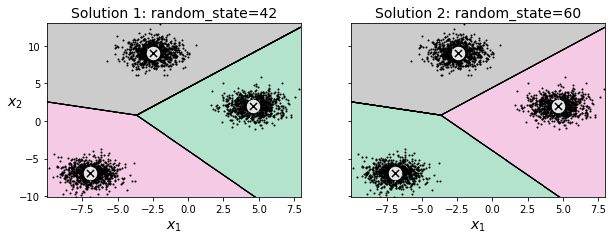

In [324]:
kmeans_rnd_init1 = KMeans(n_clusters=3, init="random", n_init=1, algorithm="full", random_state=42)
kmeans_rnd_init2 = KMeans(n_clusters=3, init="random", n_init=1, algorithm="full", random_state=60)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_bridge,
                          "Solution 1: random_state=42", "Solution 2: random_state=60")

plt.show()

See no difference!

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 3?

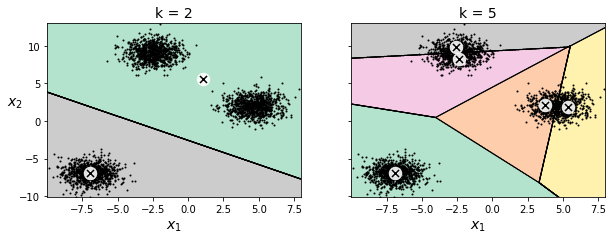

In [325]:
kmeans_k2 = KMeans(n_clusters=2, random_state=42)
kmeans_k5 = KMeans(n_clusters=5, random_state=42)

plot_clusterer_comparison(kmeans_k2, kmeans_k5, X_bridge, "k = 2", "k = 5")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [326]:
kmeans_k2.inertia_

52648.56024769457

In [327]:
kmeans_k5.inertia_

4312.252417790666

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_bridge) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

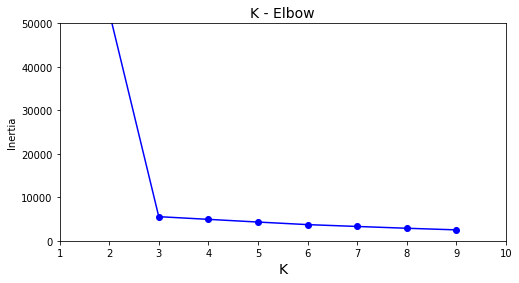

In [329]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("K", fontsize=14)
plt.ylabel("Inertia", fontsize=10)
plt.annotate('Elbow',
             xy=(3, inertias[1]),
             xytext=(0.5, 0.5),
             textcoords='figure fraction',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.5)
            )
plt.axis([1, 10, 0, 50000])
plt.title("K - Elbow", fontsize=14)
plt.show()

As you can see, there is an elbow at $k=3$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=3$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

## Plot the silhouette score as a function of $k$

In [330]:
silhouette_score(X_bridge, kmeans.labels_)

0.8425094066125479

In [0]:
silhouette_scores = [silhouette_score(X_bridge, model.labels_)
                     for model in kmeans_per_k[1:]]

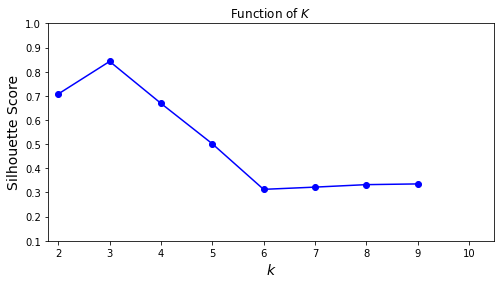

In [332]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.axis([1.8, 10.5, 0.1, 1.0])
plt.title("Function of $K$")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=3$ is the best choice.

## Use RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_bridge_train, X_bridge_test, y_bridge_train, y_bridge_test = train_test_split(X_bridge, y_pred, test_size=0.3, shuffle = True, random_state=42)

In [334]:
X_bridge_train.shape, X_bridge_test.shape, y_bridge_train.shape, y_bridge_test.shape

((1969, 2), (844, 2), (1969,), (844,))

Create the model and fit with the training set

In [335]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_bridge_train, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [336]:
cross_val_score(RF_bridge, X_bridge_train[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

1.0

Test the model using testing set

In [337]:
RF_bridge.score(X_bridge_test, y_bridge_test)

1.0

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
best_index = np.argmax(silhouette_scores)
best_model = kmeans_per_k[best_index]

In [0]:
X_train_reduced = best_model.transform(X_bridge_train)
X_test_reduced = best_model.transform(X_bridge_test)

Perform cross validation using subset size 500

In [340]:
cross_val_score(RF_bridge, X_train_reduced[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

0.8979991823581752

Test the model using testing set

In [341]:
RF_bridge.score(X_test_reduced, y_bridge_test)

0.32701421800947866

The performance is not good when using K-Means as dimensionality reduction.

## Search for the number of clusters that provides the best performance.

In [342]:
from sklearn.pipeline import Pipeline

for n_clusters in range(1,11):
    pipe_bridge = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe_bridge.fit(X_bridge_train, y_bridge_train)
    print(n_clusters, pipe_bridge.score(X_bridge_test, y_bridge_test))

1 0.6386255924170616
2 0.8921800947867299
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0


## This can be seen clearly that, n_clusters = 3 provides the best performance.

# Gaussian Mixtures

No need to use CPA for this dataset because there're only 2 features.

In [343]:
X_bridge_train.shape, X_bridge_test.shape, y_bridge_train.shape, y_bridge_test.shape

((1969, 2), (844, 2), (1969,), (844,))

Let's train a Gaussian mixture model on the training set

In [344]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X_bridge_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Let's look at the parameters that the EM algorithm estimated:

In [345]:
gm.weights_

array([0.32910107, 0.33468766, 0.33621127])

In [346]:
gm.means_

array([[-2.4957005 ,  9.01927068],
       [-6.94535147, -6.92540801],
       [ 4.62314753,  2.03479536]])

In [347]:
gm.covariances_

array([[[ 0.90598379, -0.00174758],
        [-0.00174758,  1.03581981]],

       [[ 0.95297416, -0.03320283],
        [-0.03320283,  0.92520068]],

       [[ 1.04337559,  0.02673997],
        [ 0.02673997,  0.94342209]]])

Did the algorithm actually converge?

In [348]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [349]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [350]:
gm.predict(X_bridge)

array([1, 1, 0, ..., 2, 2, 2])

In [351]:
gm.predict_proba(X_bridge)

array([[2.58896722e-49, 1.00000000e+00, 1.12487536e-38],
       [8.02456927e-53, 1.00000000e+00, 2.28621372e-41],
       [1.00000000e+00, 1.89626176e-60, 4.65543804e-25],
       ...,
       [8.52192259e-25, 4.21991935e-62, 1.00000000e+00],
       [3.95230307e-21, 1.59203878e-50, 1.00000000e+00],
       [5.04069357e-23, 1.38879745e-38, 1.00000000e+00]])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

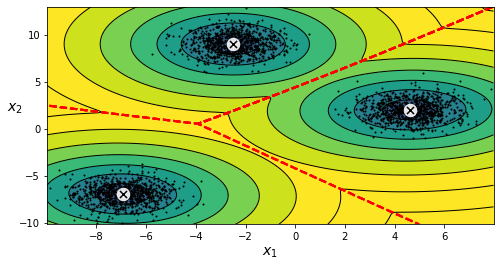

In [353]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_bridge)
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [354]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X_bridge)
gm_tied.fit(X_bridge)
gm_spherical.fit(X_bridge)
gm_diag.fit(X_bridge)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [0]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


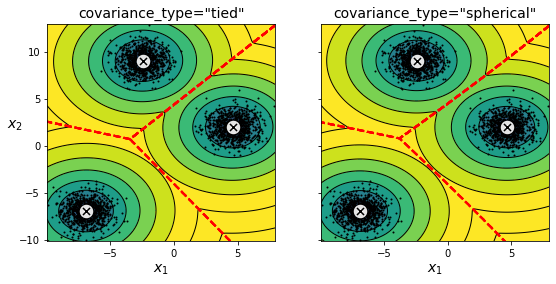

In [357]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X_bridge)
plt.show()

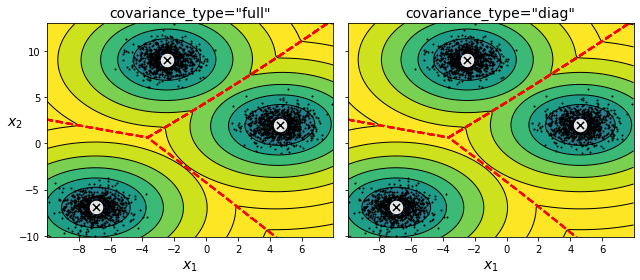

In [358]:
compare_gaussian_mixtures(gm_full, gm_diag, X_bridge)
plt.tight_layout()
plt.show()

## Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(X_bridge)
density_threshold = np.percentile(densities, 4)
anomalies = X_bridge[densities < density_threshold]

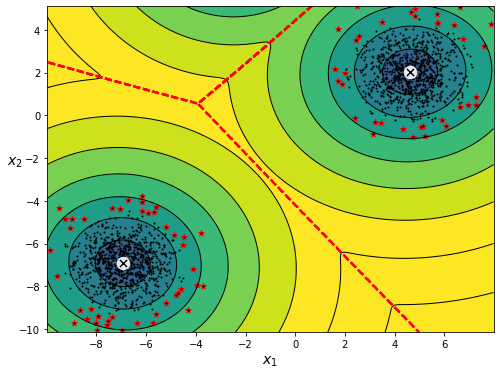

In [362]:
plt.figure(figsize=(8, 6))

plot_gaussian_mixture(gm, X_bridge)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()